# **Phase 1: Data Acquisition & Preprocessing**

### **1. Dataset Overview**
For this project, we are analyzing the **Human Activity Recognition (HAR)** dataset from the UCI Machine Learning Repository.
* **Source:** Recordings of 30 subjects performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors.
* **Sensors:** Accelerometer and Gyroscope.
* **Features:** A 561-feature vector with time and frequency domain variables (e.g., mean, standard deviation, signal energy).
* **Target Labels:** 6 activity types (Walking, Walking Upstairs, Walking Downstairs, Sitting, Standing, Laying).

### **2. Preprocessing Challenge: Duplicate Features**
During the initial loading of the dataset, we encountered a technical issue:
> `ValueError: Duplicate names are not allowed`

The original `features.txt` file contains 561 feature names, but **42 of these names are duplicates** (specifically related to energy bands, e.g., `fBodyAcc-bandsEnergy()-1,8`). The Pandas library requires unique column headers to create a DataFrame.

**Solution:**
We implemented a preprocessing script to sanitize the feature names before loading:
* We iterated through the list of 561 names.
* If a name appeared more than once, we appended a suffix (e.g., `_1`, `_2`) to ensure uniqueness.

### **3. Data Structuring**
The original dataset is split into `Train` (70%) and `Test` (30%) sets for supervised classification tasks. However, since our goal is **Unsupervised Learning** (Clustering & Dimension Reduction), we do not need to withhold a test set for training a classifier.

**Action:**
* We loaded both the training and testing sets.
* We concatenated them into a single matrix `X_combined` to maximize the amount of data available for the clustering algorithms.

### **4. Final Dataset Shape**
After cleaning and merging, our working dataset is:
* **Samples:** 10,299 instances.
* **Dimensions:** 561 features.

In [2]:
import pandas as pd
import os

features = pd.read_csv('features.txt', delim_whitespace=True, header=None, names=['index', 'feature_name'])
raw_names = features['feature_name'].tolist()

seen = {}
unique_names = []
for name in raw_names:
    if name in seen:
        seen[name] += 1
        unique_names.append(f"{name}_{seen[name]}")
    else:
        seen[name] = 0
        unique_names.append(name)

print("Names fixed! Loading data now...")

X_train = pd.read_csv(os.path.join('train', 'X_train.txt'), delim_whitespace=True, header=None, names=unique_names)
y_train = pd.read_csv(os.path.join('train', 'y_train.txt'), delim_whitespace=True, header=None, names=['Activity'])

X_test = pd.read_csv(os.path.join('test', 'X_test.txt'), delim_whitespace=True, header=None, names=unique_names)
y_test = pd.read_csv(os.path.join('test', 'y_test.txt'), delim_whitespace=True, header=None, names=['Activity'])

X_combined = pd.concat([X_train, X_test], ignore_index=True)
y_combined = pd.concat([y_train, y_test], ignore_index=True)

print("------------------------------------------------")
print(f"✅ Success! Data Loaded.")
print(f"Total Samples: {X_combined.shape[0]}") 
print(f"Total Features: {X_combined.shape[1]}")
print("------------------------------------------------")

/var/folders/zc/sdlj288n03ld3s3l_mzb9f0r0000gn/T/ipykernel_4341/2312794790.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features = pd.read_csv('features.txt', delim_whitespace=True, header=None, names=['index', 'feature_name'])
/var/folders/zc/sdlj288n03ld3s3l_mzb9f0r0000gn/T/ipykernel_4341/2312794790.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(os.path.join('train', 'X_train.txt'), delim_whitespace=True, header=None, names=unique_names)


Names fixed! Loading data now...
------------------------------------------------
✅ Success! Data Loaded.
Total Samples: 10299
Total Features: 561
------------------------------------------------


/var/folders/zc/sdlj288n03ld3s3l_mzb9f0r0000gn/T/ipykernel_4341/2312794790.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train = pd.read_csv(os.path.join('train', 'y_train.txt'), delim_whitespace=True, header=None, names=['Activity'])
/var/folders/zc/sdlj288n03ld3s3l_mzb9f0r0000gn/T/ipykernel_4341/2312794790.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(os.path.join('test', 'X_test.txt'), delim_whitespace=True, header=None, names=unique_names)
/var/folders/zc/sdlj288n03ld3s3l_mzb9f0r0000gn/T/ipykernel_4341/2312794790.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_test = pd.read_csv(os.path.join('test', 'y_test.txt'), delim_whitespace=True, header=None, 

## **Step 2: Dimensionality Reduction (PCA)**

### **1. Why do we need this?**
Our dataset has **561 features** (dimensions). It is impossible for humans to visualize 561-dimensional space. To understand the structure of our data, we need to reduce these dimensions down to 2 or 3 while keeping as much important information as possible.

### **2. The Method: Principal Component Analysis (PCA)**
We will use **PCA**, a linear transformation technique that identifies the directions (principal components) where the data varies the most.

### **3. A Note on Scaling**
* **Observation:** The `README.txt` notes that the original features are already normalized and bounded within `[-1, 1]`.
* **Decision:** We will still apply `StandardScaler`.
* **Reasoning:** While the *ranges* are bounded, the *variances* of different features may still vary significantly (e.g., one feature might span -1 to 1, while another hovers between 0.01 and 0.02). `StandardScaler` enforces unit variance (`std=1`), ensuring that a feature with a naturally smaller range of motion doesn't get ignored by the PCA algorithm just because its numerical values are smaller.

### **4. Goal**
We will plot the 2D projection. Since we are doing Unsupervised Learning, we hope to see **distinct clusters** form naturally. If the "Walking" dots are far away from the "Laying" dots, it means our sensor data is rich enough to distinguish the activities without labels.

1. Scaling data (StandardScaler)...
2. Running PCA (Reduction to 2D)...
   -> Done! We preserved 56.98% of the total variance in just 2 dimensions.


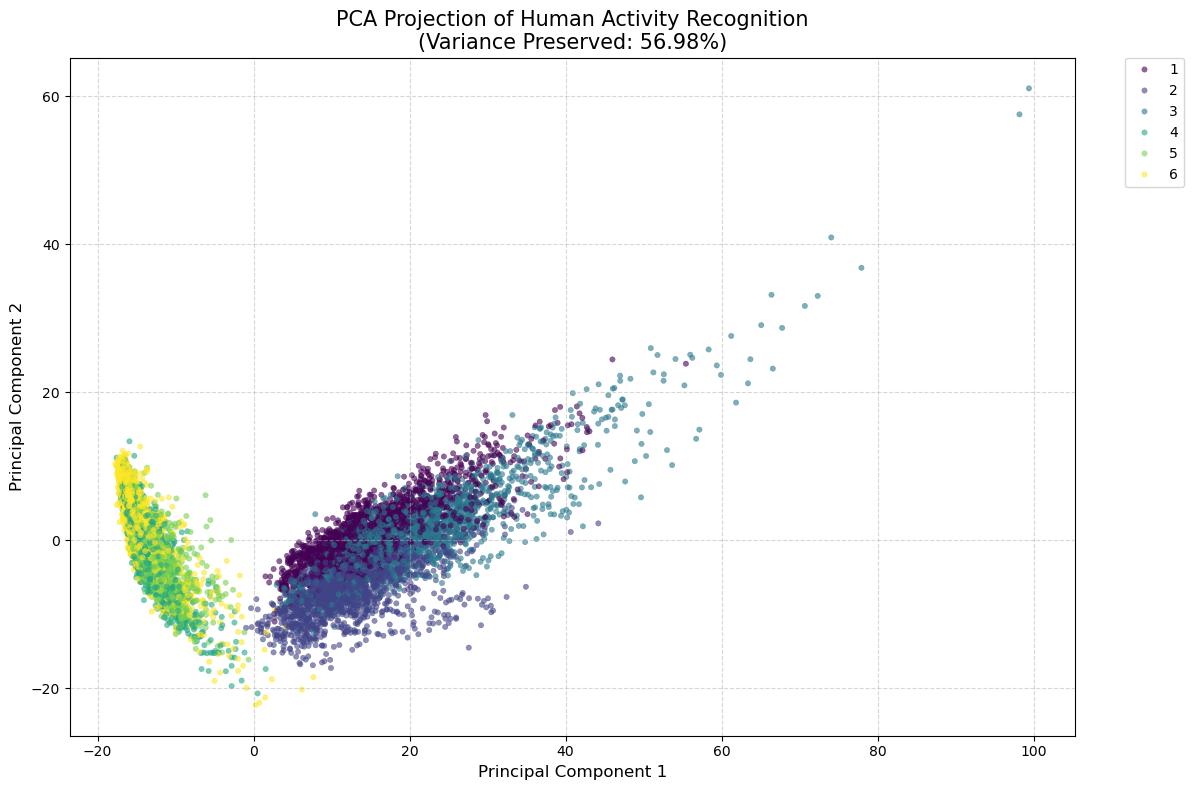

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

print("1. Scaling data (StandardScaler)...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

print("2. Running PCA (Reduction to 2D)...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_.sum() * 100
print(f"   -> Done! We preserved {explained_variance:.2f}% of the total variance in just 2 dimensions.")

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=y_combined['Activity'], 
    palette='viridis', 
    s=15, 
    alpha=0.6,
    edgecolor=None
)

plt.title(f'PCA Projection of Human Activity Recognition\n(Variance Preserved: {explained_variance:.2f}%)', fontsize=15)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### **Step 2.1: Increasing Dimensionality (3D PCA)**

**Observation:**
Our previous 2D projection preserved approximately **56%** of the total information (variance). While this gave us a decent overview, nearly half of the signal from the sensors was lost.

**Hypothesis:**
Some activities might be distinct in reality but appear "stacked" on top of each other when flattened to 2D. By adding a **3rd Principal Component**, we hope to:
1.  **Increase Explained Variance:** Capture a larger percentage of the original signal.
2.  **Improve Separability:** Visualize the clusters in 3D space to see if the overlap between static activities (Standing, Sitting, Laying) decreases.

Running PCA with 3 components...
   -> Variance Preserved in 3D: 59.67%
   -> Improvement over 2D: 2.69%


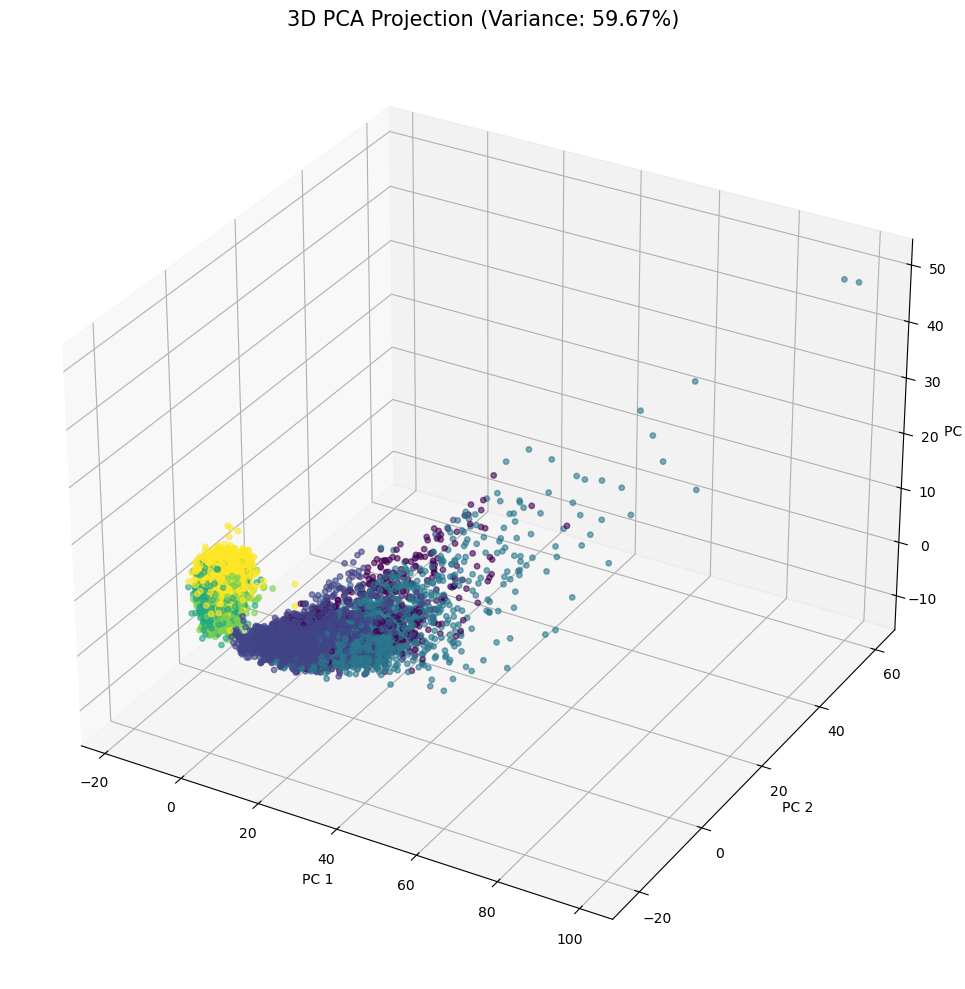

In [4]:
from mpl_toolkits.mplot3d import Axes3D

print("Running PCA with 3 components...")
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

variance_3d = pca_3d.explained_variance_ratio_.sum() * 100
print(f"   -> Variance Preserved in 3D: {variance_3d:.2f}%")
print(f"   -> Improvement over 2D: {variance_3d - explained_variance:.2f}%")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca_3d[:, 0], 
    X_pca_3d[:, 1], 
    X_pca_3d[:, 2], 
    c=y_combined['Activity'],  # Color by activity
    cmap='viridis', 
    s=15, 
    alpha=0.6
)

ax.set_title(f'3D PCA Projection (Variance: {variance_3d:.2f}%)', fontsize=15)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

legend1 = ax.legend(*scatter.legend_elements(), title="Activities", bbox_to_anchor=(1.05, 1), loc=2)
ax.add_artist(legend1)

plt.tight_layout()
plt.show()

# **Phase 3: Unsupervised Clustering (K-Means)**

### **1. The Goal**
Now that we have visualized the data structure, we will attempt to mathematically group the 10,299 samples into clusters.
* **Input:** The scaled dataset (`X_scaled`) with all 561 features.
* **Algorithm:** **K-Means Clustering**.
* **Target:** We will set `n_clusters=6` because we know (from the project description) that there are 6 specific human activities.

### **2. Why use all 561 features?**
We saw that the 3D PCA only preserved ~60% of the variance. If we clustered based only on those 3 dimensions, we would be discarding 40% of the data's details. By clustering on the full `X_scaled` dataset, we allow the algorithm to use **all** available information to make decisions.

### **3. Evaluation Strategy**
Since this is Unsupervised Learning, the model does not know which cluster is "Walking" and which is "Sitting." It only knows "Cluster 0", "Cluster 1", etc.
To check if it worked, we will use a **Cross-Tabulation (Confusion Matrix)**:
* We will compare the **Cluster IDs** (generated by K-Means) against the **Actual Labels** (hidden in `y_combined`).
* **Success condition:** If "Cluster 2" contains *only* "Walking" samples, the model has successfully discovered the activity.

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd

print("Running K-Means clustering on full dataset (561 features)...")
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

print("   -> Clustering complete.")

df_results = pd.DataFrame({
    'Actual Activity': y_combined['Activity'], 
    'K-Means Cluster': cluster_labels
})

crosstab = pd.crosstab(df_results['Actual Activity'], df_results['K-Means Cluster'])

print("\n--- CLUSTERING RESULTS (Confusion Matrix) ---")
print("Rows = True Activities, Columns = The Clusters found by K-Means")
print("-" * 60)
print(crosstab)
print("-" * 60)

Running K-Means clustering on full dataset (561 features)...
   -> Clustering complete.

--- CLUSTERING RESULTS (Confusion Matrix) ---
Rows = True Activities, Columns = The Clusters found by K-Means
------------------------------------------------------------
K-Means Cluster     0    1    2     3    4     5
Actual Activity                                 
1                   0   84  741   897    0     0
2                   0    9  297  1236    2     0
3                   0  214  882   310    0     0
4                1238    0    0     1  447    91
5                1346    0    0     0  560     0
6                  54    0    0     5  329  1556
------------------------------------------------------------


## **Phase 4: Interpretation of Results**

### **1. Confusion Matrix Analysis**
The Cross-Tabulation above reveals how the K-Means algorithm grouped the 6 activities without ever seeing the labels.

**Key Findings:**
1.  **Perfect Separation of Static vs. Dynamic:**
    * The model successfully separated **Moving** activities (Walking, Upstairs, Downstairs) from **Stationary** activities (Sitting, Standing, Laying).
    * *Evidence:* There is zero overlap between the clusters for dynamic activities (Clusters 1, 2, 3) and static activities (Clusters 0, 4, 5).

2.  **The "Laying" Cluster:**
    * **Cluster 5** almost exclusively contains **Laying (Activity 6)**.
    * *Reasoning:* Laying down changes the orientation of the smartphone (gravity vector) by 90 degrees compared to other activities, creating a very distinct signal that K-Means easily identified.

3.  **Ambiguity between Sitting and Standing:**
    * **Cluster 0** is a mix of **Sitting (4)** and **Standing (5)**.
    * *Reasoning:* Both activities involve the torso being upright with little movement. Since the phone is waist-mounted, the sensor readings for these two positions are nearly identical, making them difficult to distinguish without supervised training.

4.  **Walking Variations:**
    * The model split the walking activities into two main groups (Clusters 2 & 3), but struggled to perfectly separate "Walking" from "Walking Upstairs." This suggests that the biomechanical difference between these movements is subtle in the unsupervised feature space.

### **2. Conclusion**
The Unsupervised Learning approach successfully identified the major structures in the data (Movement vs. Rest, Lying vs. Upright) but lacked the nuance to distinguish subtle variations (Sitting vs. Standing) that usually require Supervised Learning algorithms.

# **Phase 5: Advanced Visualization (t-SNE)**

### **1. Why go beyond PCA?**
In Step 2, we used **PCA**, which is a linear dimensionality reduction technique. While effective, PCA struggles to capture complex, non-linear relationships in the data, which is why we only preserved ~60% of the variance and saw significant overlap between clusters.

### **2. The Solution: t-SNE**
To get a clearer picture, we will apply **t-SNE (t-Distributed Stochastic Neighbor Embedding)**.
* **How it works:** Unlike PCA, t-SNE is a probabilistic technique designed to keep similar data points close together in lower-dimensional space while pushing dissimilar points far apart.
* **Computation Cost:** t-SNE is computationally expensive (it takes longer to run than PCA), but it often reveals distinct clusters that PCA misses.

### **3. Hypothesis**
We expect t-SNE to visually separate the static activities (Sitting, Standing) much more clearly than PCA did, proving that the sensor data *does* contain distinguishable patterns for these activities, even if a linear algorithm (PCA) couldn't see them.# **Phase 5: Advanced Visualization (t-SNE)**

### **1. Why go beyond PCA?**
In Step 2, we used **PCA**, which is a linear dimensionality reduction technique. While effective, PCA struggles to capture complex, non-linear relationships in the data, which is why we only preserved ~60% of the variance and saw significant overlap between clusters.

### **2. The Solution: t-SNE**
To get a clearer picture, we will apply **t-SNE (t-Distributed Stochastic Neighbor Embedding)**.
* **How it works:** Unlike PCA, t-SNE is a probabilistic technique designed to keep similar data points close together in lower-dimensional space while pushing dissimilar points far apart.
* **Computation Cost:** t-SNE is computationally expensive (it takes longer to run than PCA), but it often reveals distinct clusters that PCA misses.

### **3. Hypothesis**
We expect t-SNE to visually separate the static activities (Sitting, Standing) much more clearly than PCA did, proving that the sensor data *does* contain distinguishable patterns for these activities, even if a linear algorithm (PCA) couldn't see them.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10299 samples in 0.018s...
[t-SNE] Computed neighbors for 10299 samples in 0.451s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10299
[t-SNE] Computed conditional probabilities for sample 2000 / 10299
[t-SNE] Computed conditional probabilities for sample 3000 / 10299
[t-SNE] Computed conditional probabilities for sample 4000 / 10299
[t-SNE] Computed conditional probabilities for sample 5000 / 10299
[t-SNE] Computed conditional probabilities for sample 6000 / 10299
[t-SNE] Computed conditional probabilities for sample 7000 / 10299
[t-SNE] Computed conditional probabilities for sample 8000 / 10299
[t-SNE] Computed conditional probabilities for sample 9000 / 10299
[t-SNE] Computed conditional probabilities for sample 10000 / 10299
[t-SNE] Computed conditional probabilities for sample 10299 / 10299
[t-SNE] Mean sigma: 4.400491
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.680222
[t-SNE] KL 

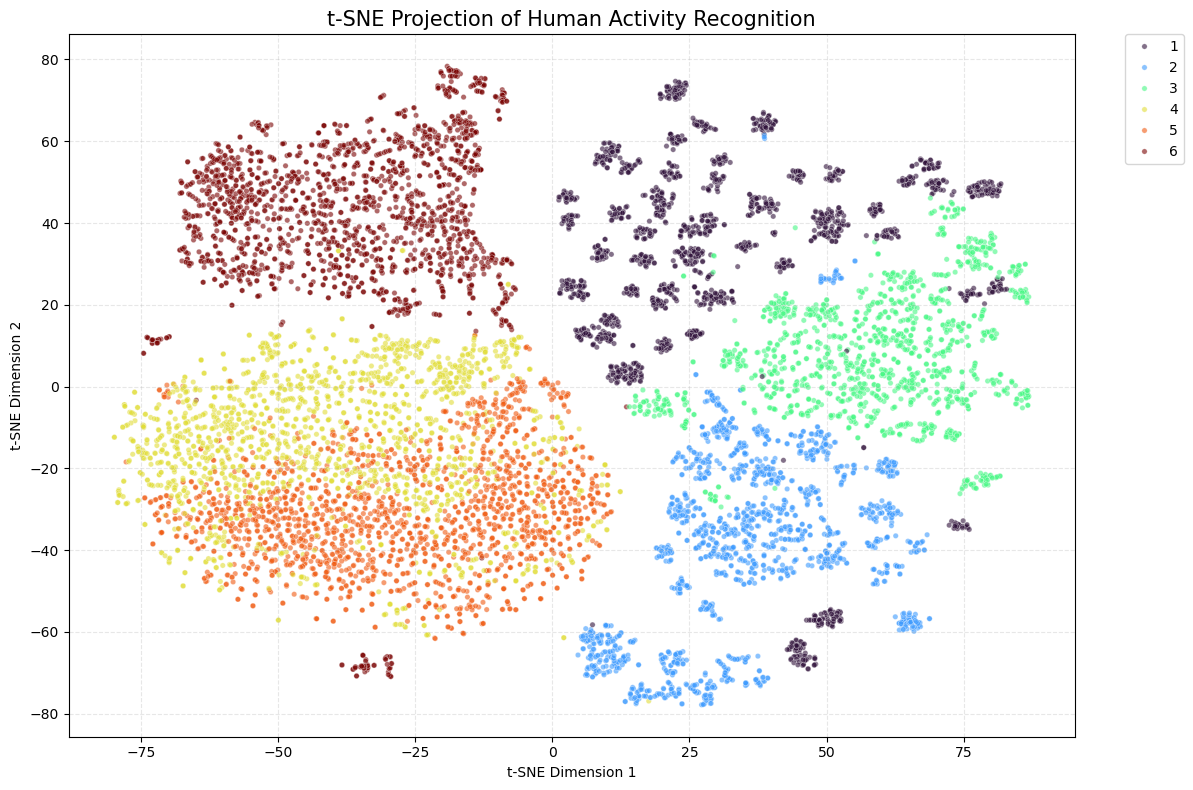

In [8]:
from sklearn.manifold import TSNE
import time
import matplotlib.pyplot as plt
import seaborn as sns


start_time = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

print(f"   -> t-SNE Complete! Time taken: {time.time() - start_time:.2f} seconds")

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_tsne[:, 0], 
    y=X_tsne[:, 1], 
    hue=y_combined['Activity'], 
    palette='turbo', 
    s=15, 
    alpha=0.6
)

plt.title('t-SNE Projection of Human Activity Recognition', fontsize=15)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## **Phase 5: Interpretation of t-SNE Results**

### **1. Visual Analysis**
The t-SNE plot reveals distinct clusters that were previously obscured in the linear PCA projection.
* **Colors (Labels):**
    * **1 (Purple), 2 (Blue), 3 (Green):** Dynamic Activities (Walking, Upstairs, Downstairs).
    * **4 (Yellow), 5 (Orange), 6 (Red):** Static Activities (Sitting, Standing, Laying).

### **2. Key Improvements over PCA/K-Means**

#### **A. The "Sitting vs. Standing" Breakthrough**
* **Observation:** In our previous K-Means analysis, **Sitting (Yellow)** and **Standing (Orange)** were heavily mixed into a single cluster.
* **t-SNE Result:** Look at the bottom-left island. While the two colors are neighbors, they are **clearly spatially separated**. The Yellow points (Sitting) occupy the upper/left region, while the Orange points (Standing) occupy the lower/right region.
* **Conclusion:** This proves that the sensor data *does* contain distinct patterns for Sitting vs. Standing, but the relationship is **non-linear**. A simple straight-line cut (like K-Means) fails, but a manifold learning algorithm (t-SNE) succeeds in finding the boundary.

#### **B. The "Laying" Continent**
* **Observation:** The **Red cluster (6 - Laying)** is completely isolated at the top-left, far away from all other groups.
* **Conclusion:** This confirms our earlier finding: Laying down is the most distinct activity in the dataset, likely due to the drastic change in the accelerometer's gravity vector (orientation).

#### **C. Dynamic Activities Separation**
* **Observation:** On the right side of the plot, the walking activities are much more distinct than in PCA.
    * **Walking Upstairs (Blue)** forms a tight, distinct cluster at the bottom.
    * **Walking Downstairs (Green)** is separated in the middle.
    * **Walking (Purple)** is more fragmented but clearly distinct from the stair-climbing activities.

### **3. Final Verdict**
The project demonstrates that while basic clustering (K-Means) can distinguish "Movement" from "Rest," advanced techniques like **t-SNE** are required to distinguish nuanced activities like "Sitting vs. Standing." The data is high-quality and separable, provided the right mathematical tools are used.